# WGAN-GP

In [1]:
import os
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from IPython.display import clear_output
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import gstlearn as gl
from sksparse.cholmod import cholesky

import func.propagation as prop
import func.velmodel as vmod

device = 'gpu'
labelsize = 16

# from google.colab import drive
# drive.mount('/content/drive')

2023-10-19 14:43:20.876746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 14:43:21.015223: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-19 14:43:21.502862: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yxie-l/anaconda3/envs/geostat/lib/
2023-10-19 14:43:21.502912: W tensorflow/comp

## Load Dataset

2023-10-19 14:43:22.287570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-19 14:43:22.288535: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-19 14:43:22.289213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-19 14:43:22.290114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

(2816, 40, 120, 1)


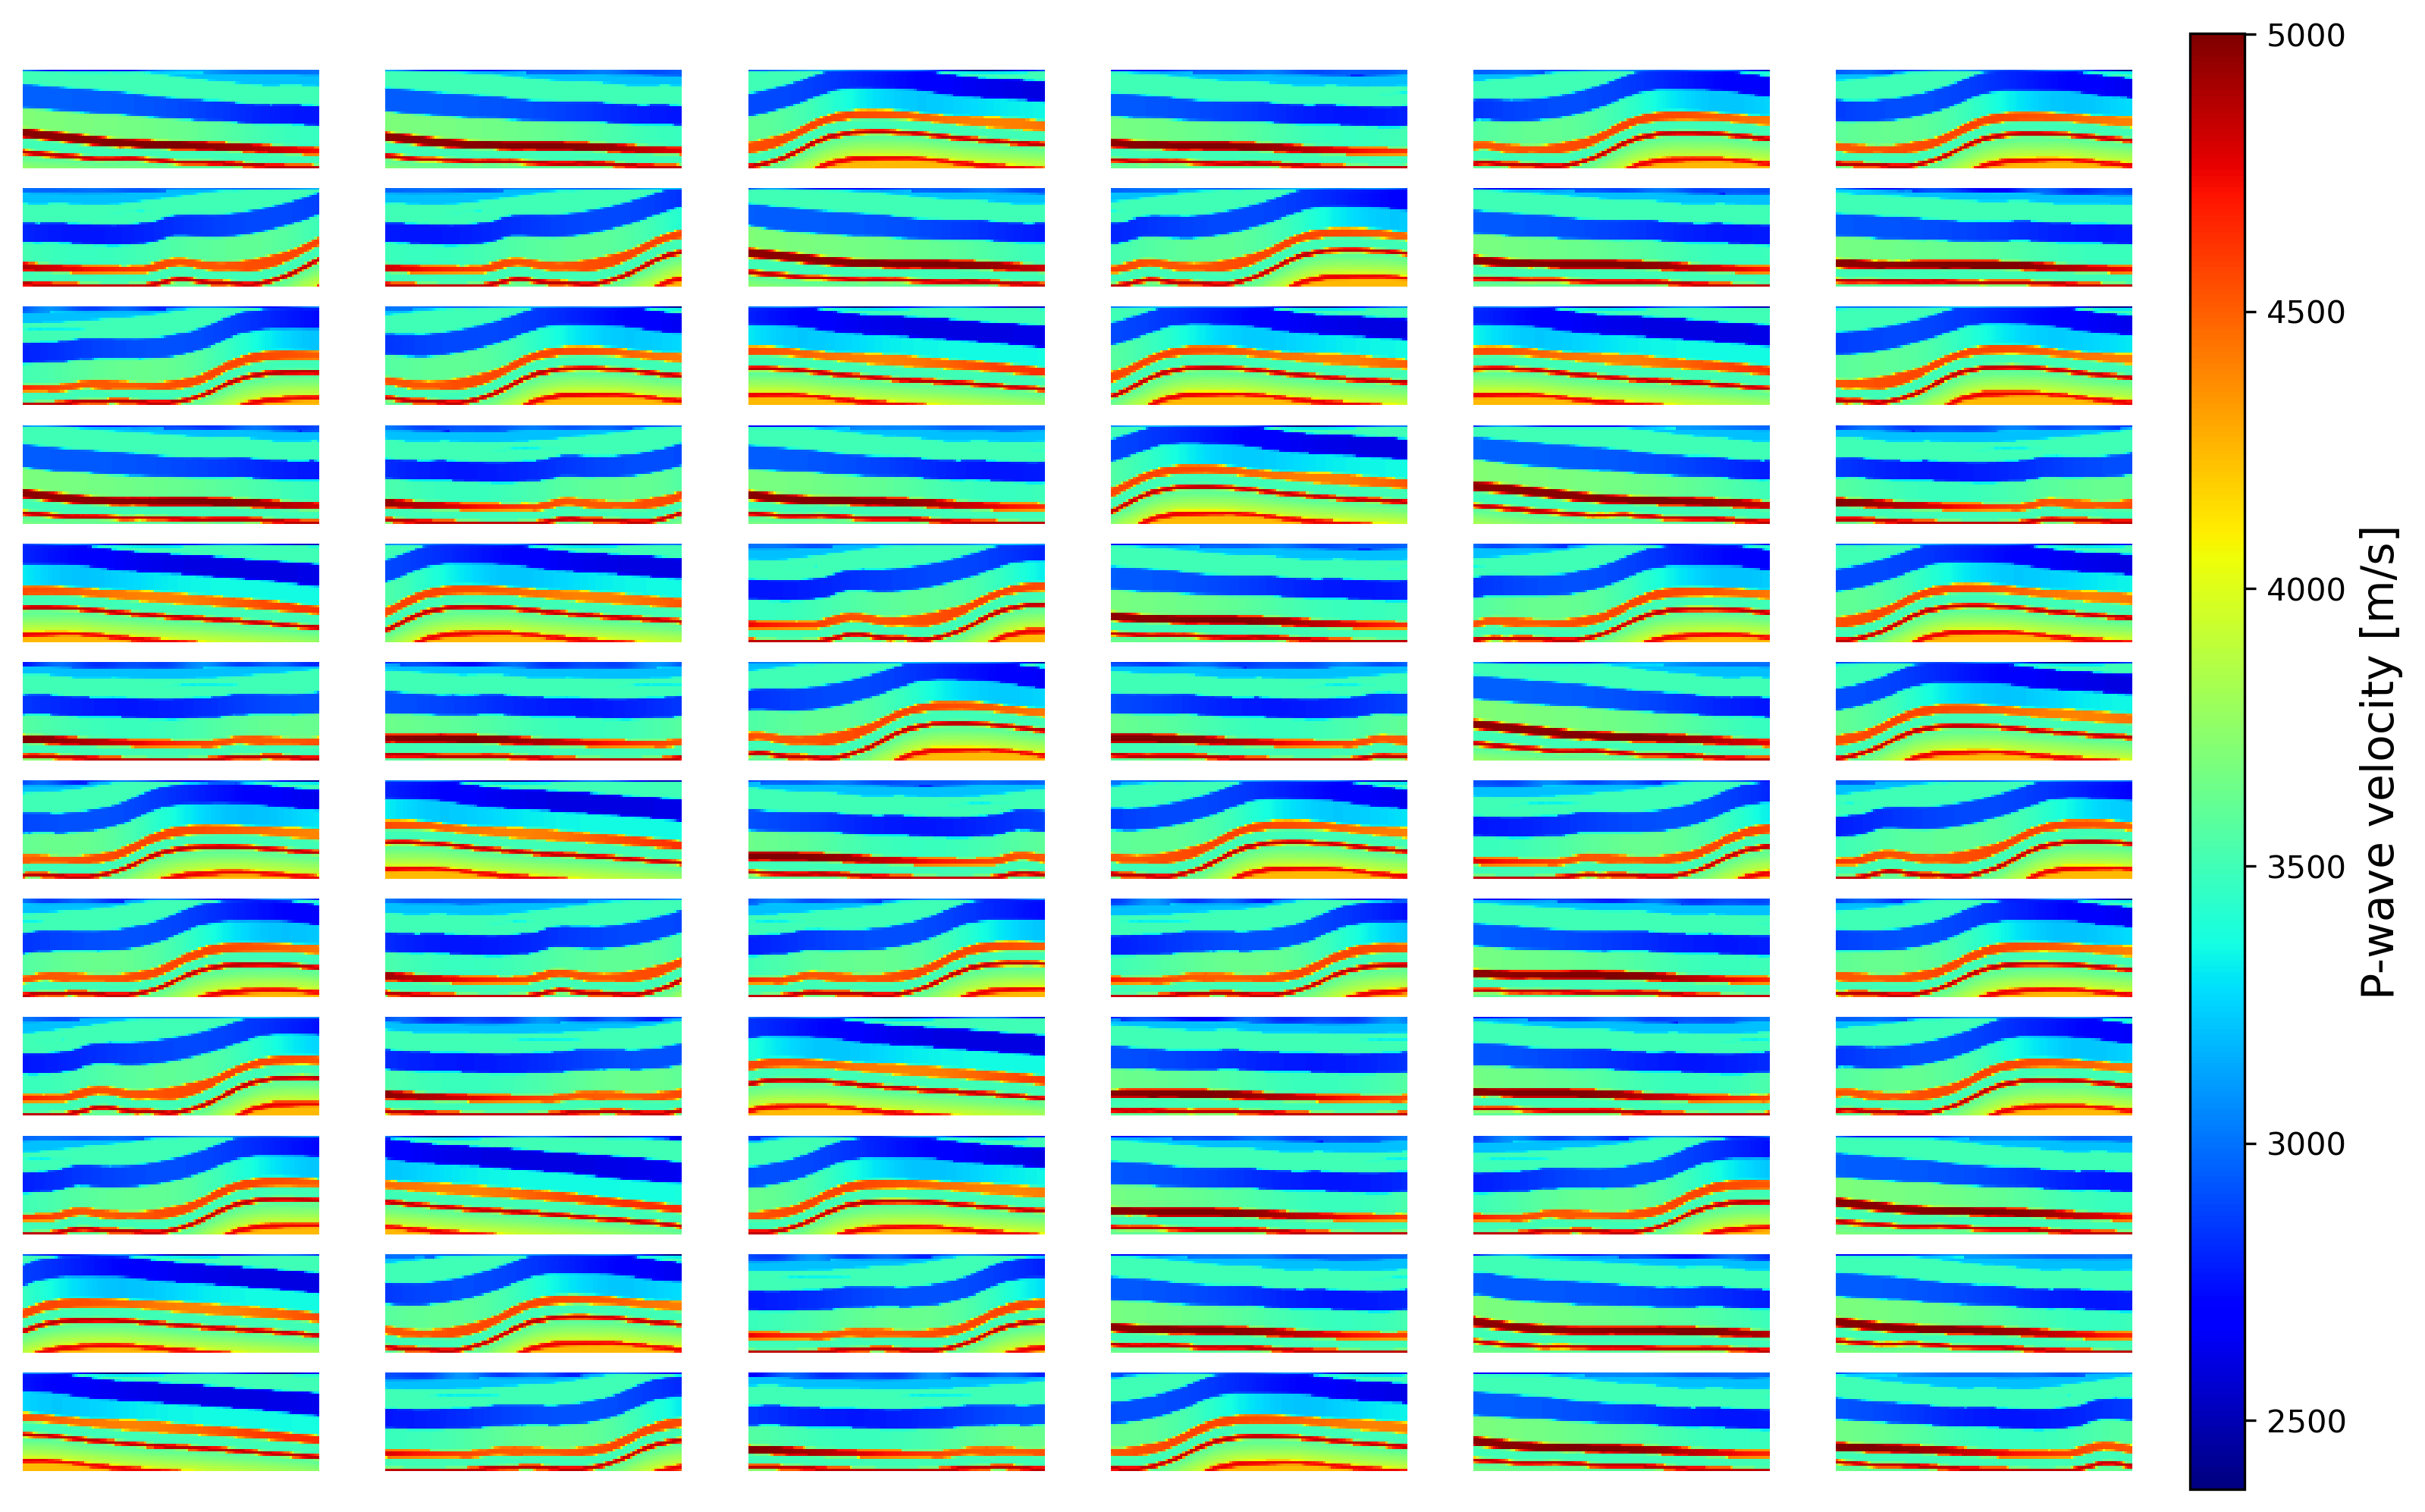

In [2]:
# n1=93 n2=401 n3=401 d1=d2=d3=50m
vel = vmod.readbin('../dataset/velocity/overthrust.bin',93,401*401)
# vel = vmod.readbin('/content/drive/MyDrive/yxieg/notebook/v.bin',93,401*401)
vel = np.reshape(vel,[93,401,401])
n = 120
vel = vel[:41, :, 60:70]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape
    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])
    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//8 # Interval on x-axis
y_interval = crop_size[1]//8  # Interval on y-axis

z_interval = 1  # Interval on z-axis
x_interval = 1 # Interval on x-axis
y_interval = 1  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')
cropped_images = cropped_images[:int(n_img - n_img%256),:,:,:]

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(12, 8), dpi=300)
for i in range(72):
  plt.subplot(12, 6, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
# Show the plot
plt.show()


# Forward Modeling

Min velocity: 2432.29  Max velocity 4850.00
dz,dx,dt (m): 9.504880859375 9.504880859375 0.0012094673270528794
Model dimension [nz,nx,nt]:  40 120 400


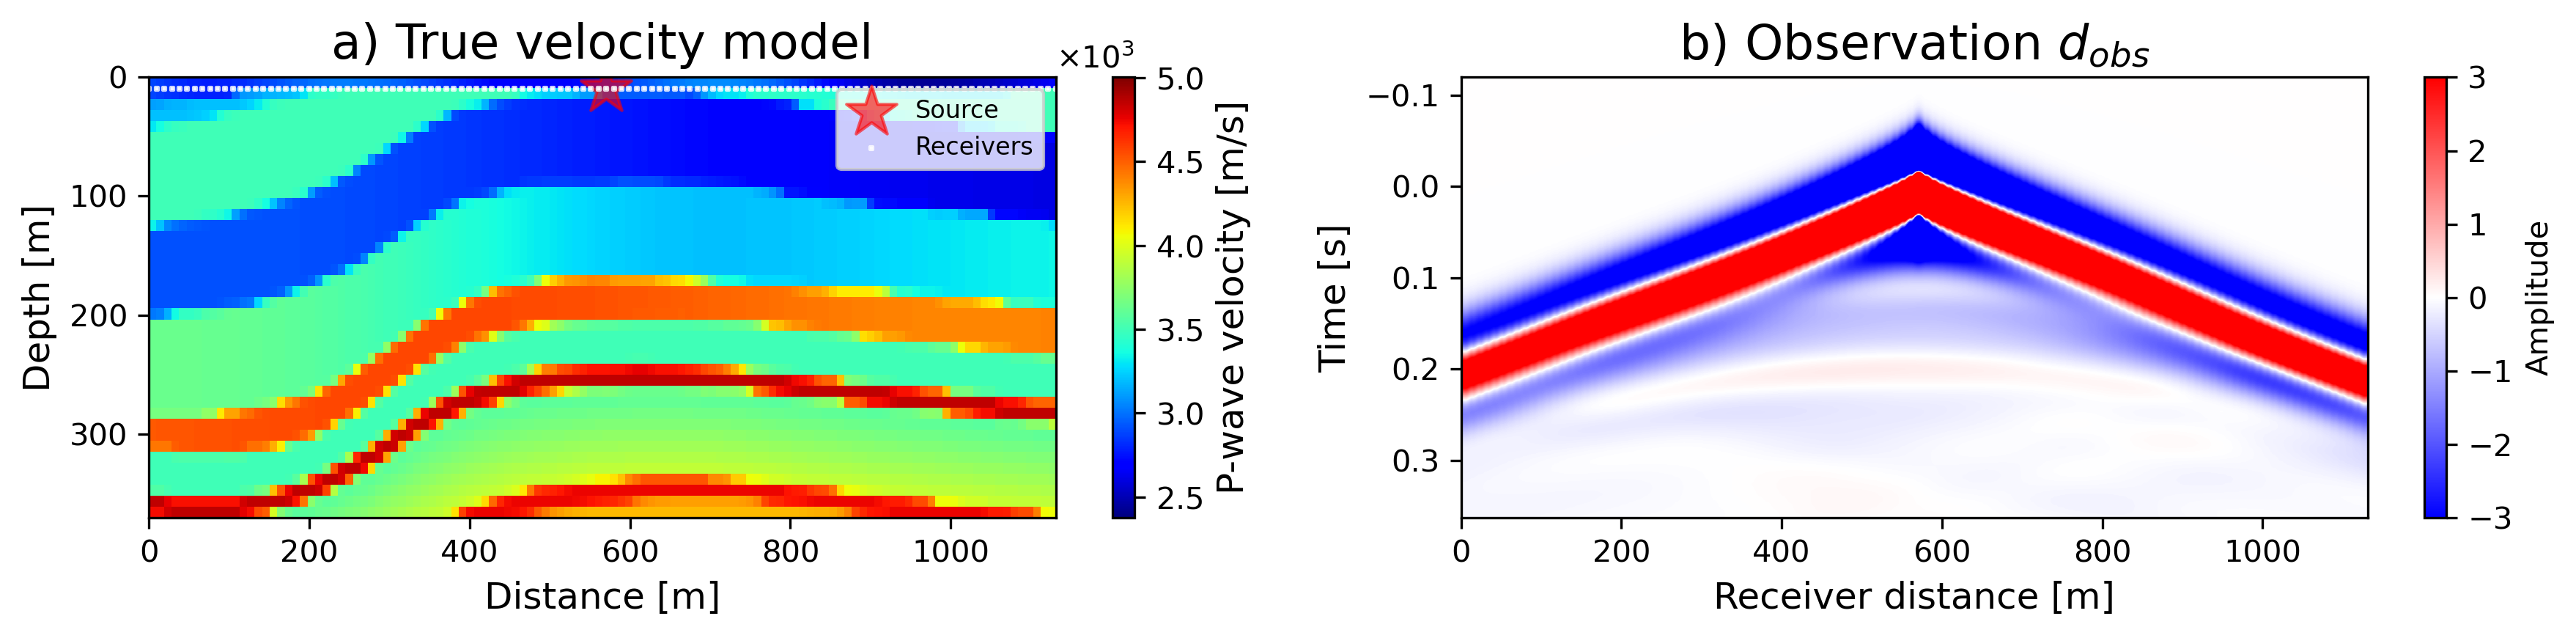

In [9]:
from matplotlib.colors import LightSource

def disp_fwd(vel, d_obs):
	plt.figure(figsize=(12,3), dpi=300)
	plt.subplot(1,2,1) 
	plt.imshow(vel.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("a) True velocity model",fontsize=labelsize)

	plt.subplot(1,2,2)
	ls = LightSource(azdeg=0, altdeg=1)
	seismic_data = tf.transpose(d_obs[0]).numpy()
	# plt.imshow(ls.hillshade(seismic_data, vert_exag=1, fraction=1.0), cmap='gray',vmin=-5,vmax=5,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	plt.imshow(seismic_data,cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.set_label("Amplitude")
	plt.title("b) Observation $d_{obs}$", fontsize=labelsize)
	plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
	plt.ylabel('Time [s]', fontsize=labelsize-4)
	plt.tight_layout()
	plt.show()
     

# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,400
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

## Marmsi2
# vel   = vmod.readbin('../dataset/velocity/marm2_sel.dat',201,601)
# vel = vel[::4,::4][-40:,-140:-20]*1e3
# vel = (vel - vel.min()) / (vel.max() - vel.min())
# v_ref = vmin + vel*(vmax-vmin)

v_ref = cropped_images[200,:,:,0].numpy()
# v_ref = cropped_images[530,:,:,0].numpy()

# seed = tf.random.normal([num_examples_to_generate, dim_z])
# Gz = generator(seed, training=False)
# Gz_i = inverse_norm(Gz[0,:,:,0],vmin,vmax)
# v_ref = Gz_i.numpy().flatten()
mu=0

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = prop.defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]

# Set sourse and receiver coordinates: shape=(2,nrec)
zxsrc = np.array([[1], [3*nx//6]]) # Single Sourse
# zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
zxrec = np.vstack((np.ones(nx), np.arange(0,nx))).astype(int) # Receivers everywhere at top

nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop.prop2d(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next, device='cpu')
  d_obs.append(d_obs_i)

disp_fwd(v_ref, d_obs)

# Conditional Generator

## Create Gaussian Prior for Linear Generation

In [4]:
def simulate(ranges = [5,10], variance = 10, param = 1, nx = [100,100],mu=2500):
    #Creation of the covariance model (Whittle-Matérn prior)
    model = gl.Model.createFromParam(gl.ECov.BESSEL_K,param = param,
                                     sill = variance, ranges = ranges)
    
    #Creation of the grid 
    mesh = gl.MeshETurbo(nx)
    
    #Creation of the precision matrix (inverse of the covariance)
    precisionOpMat = gl.PrecisionOpCs(mesh,model,0,gl.EPowerPT.ONE,False)
    Qtr = gl.csToTriplet(precisionOpMat.getQ())
    Qmat = sc.sparse.csc_matrix((np.array(Qtr.values), (np.array(Qtr.rows), np.array(Qtr.cols))))
    
    # #Reshape Q matrix
    ind = np.arange(Qmat.shape[0])
    ind =np.reshape(ind,(nx[1],nx[0])).T.flatten()
    Qmat = Qmat[ind,:][:,ind]

    L = tf.linalg.cholesky(Qmat.todense().astype(np.float32))
    
    return Qmat, tf.transpose(L)

def linear_generator(u, Lt):
  x = tf.linalg.solve(Lt, u)
  return x

def mapping(m, a=2000, b=3000):
	v = a+(b-a)/(1+tf.math.exp(-m))
	return v

# Q, Lt = simulate(ranges = [20,800], param=1.,nx=[nz,nx], variance=1, mu=0)
Q, Lt = simulate(ranges = [10,500], param=1., nx=[nz,nx], variance=2, mu=0)

2023-10-19 14:43:51.630805: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x68512c0


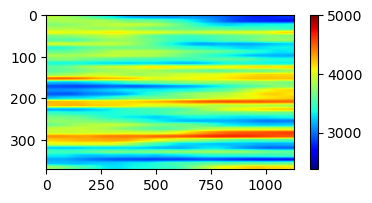

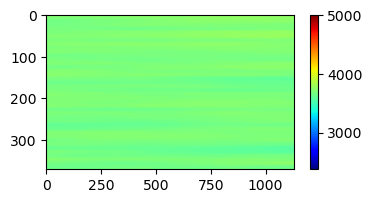

In [6]:
loss_tracker = []
dim_z = nz*nx
BATCH_SIZE = 128
noise_batch = tf.random.normal([dim_z, BATCH_SIZE])
# Generate a new image
m = linear_generator(noise_batch, Lt)
vel = mapping(m, a=vmin, b=vmax)
v_init = tf.reduce_mean(vel,axis=1)

plt.figure(figsize=(4,2),dpi=100)
plt.imshow(tf.reshape(vel[:,0], [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
plt.colorbar()

plt.figure(figsize=(4,2),dpi=100)
plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
plt.colorbar()

## Create Inference Network

In [10]:
# Define the dimensionality of the Inference and Latent Gaussian distributions
dim_w = dim_z

# Create the inference network I
def make_inference_model():
  model = tf.keras.Sequential()
  
  # Fully connected layer with SeLU activation
  model.add(layers.Dense(512, activation='selu', input_shape=(dim_w,)))
  
  # Additional fully connected layers with SeLU activations
  model.add(layers.Dense(512, activation='selu'))
  model.add(layers.Dense(512, activation='selu'))
  model.add(layers.Dense(512, activation='selu'))
  
  # Output layer mapping to dim_z
  model.add(layers.Dense(dim_w))
  
  return model


@tf.custom_gradient
def dJ_dm(vel):
  loss_J = prop.misfit(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
  loss_J = tf.cast(loss_J, tf.float32)

  def grad_fn(upstream):
      grad = prop.adjoint_gradient(vel.numpy(),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
      return upstream * tf.cast(grad, tf.float32)
  return loss_J, grad_fn


inference_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 50000
num_examples_to_generate = 50
seed = tf.random.normal([dim_z, num_examples_to_generate])

# Create an instance of the inference network I
inference_network = make_inference_model()
checkpoint_dir = '../dataset/checkpoint/wgan_gp/inference_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(inference_optimizer=inference_optimizer,
                                 inference_network=inference_network)

restore = 0
if restore==True: checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


BATCH_SIZE = 32
loss_tracker = []
sigma2 = 1e-  # Noise level
epoch_vels = []

## Apply gradient to Inference Network

Iteration 59


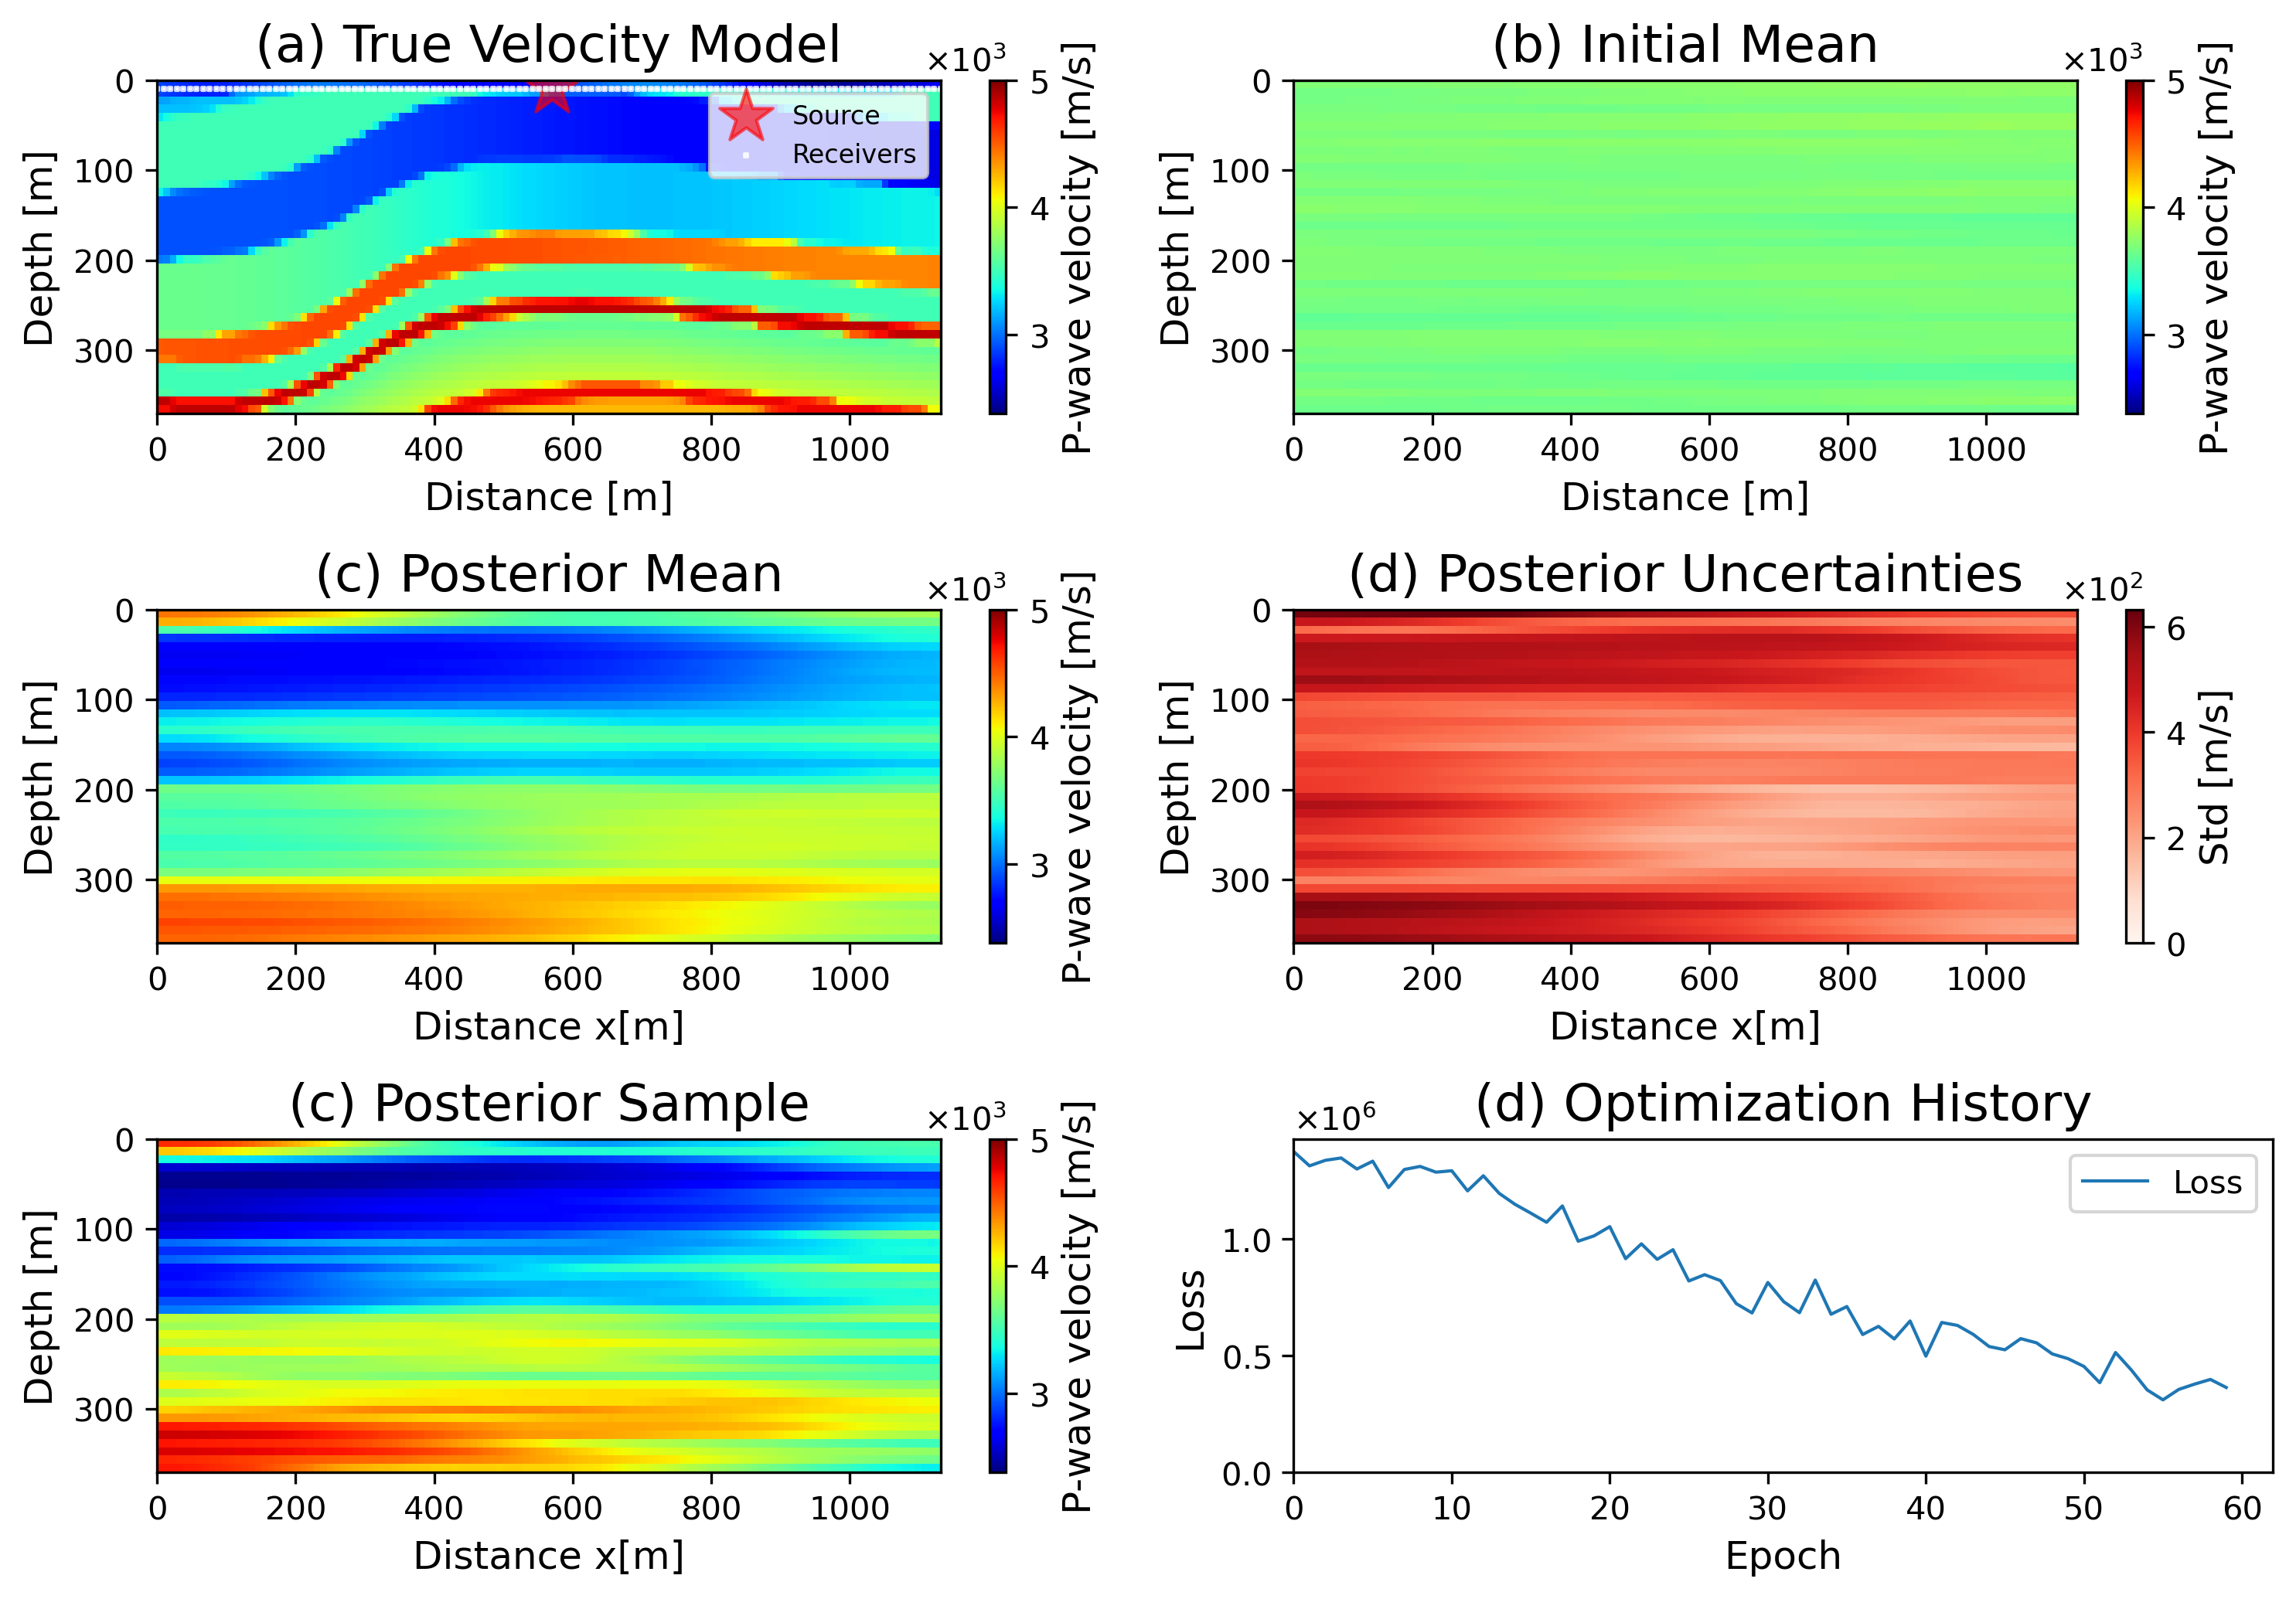

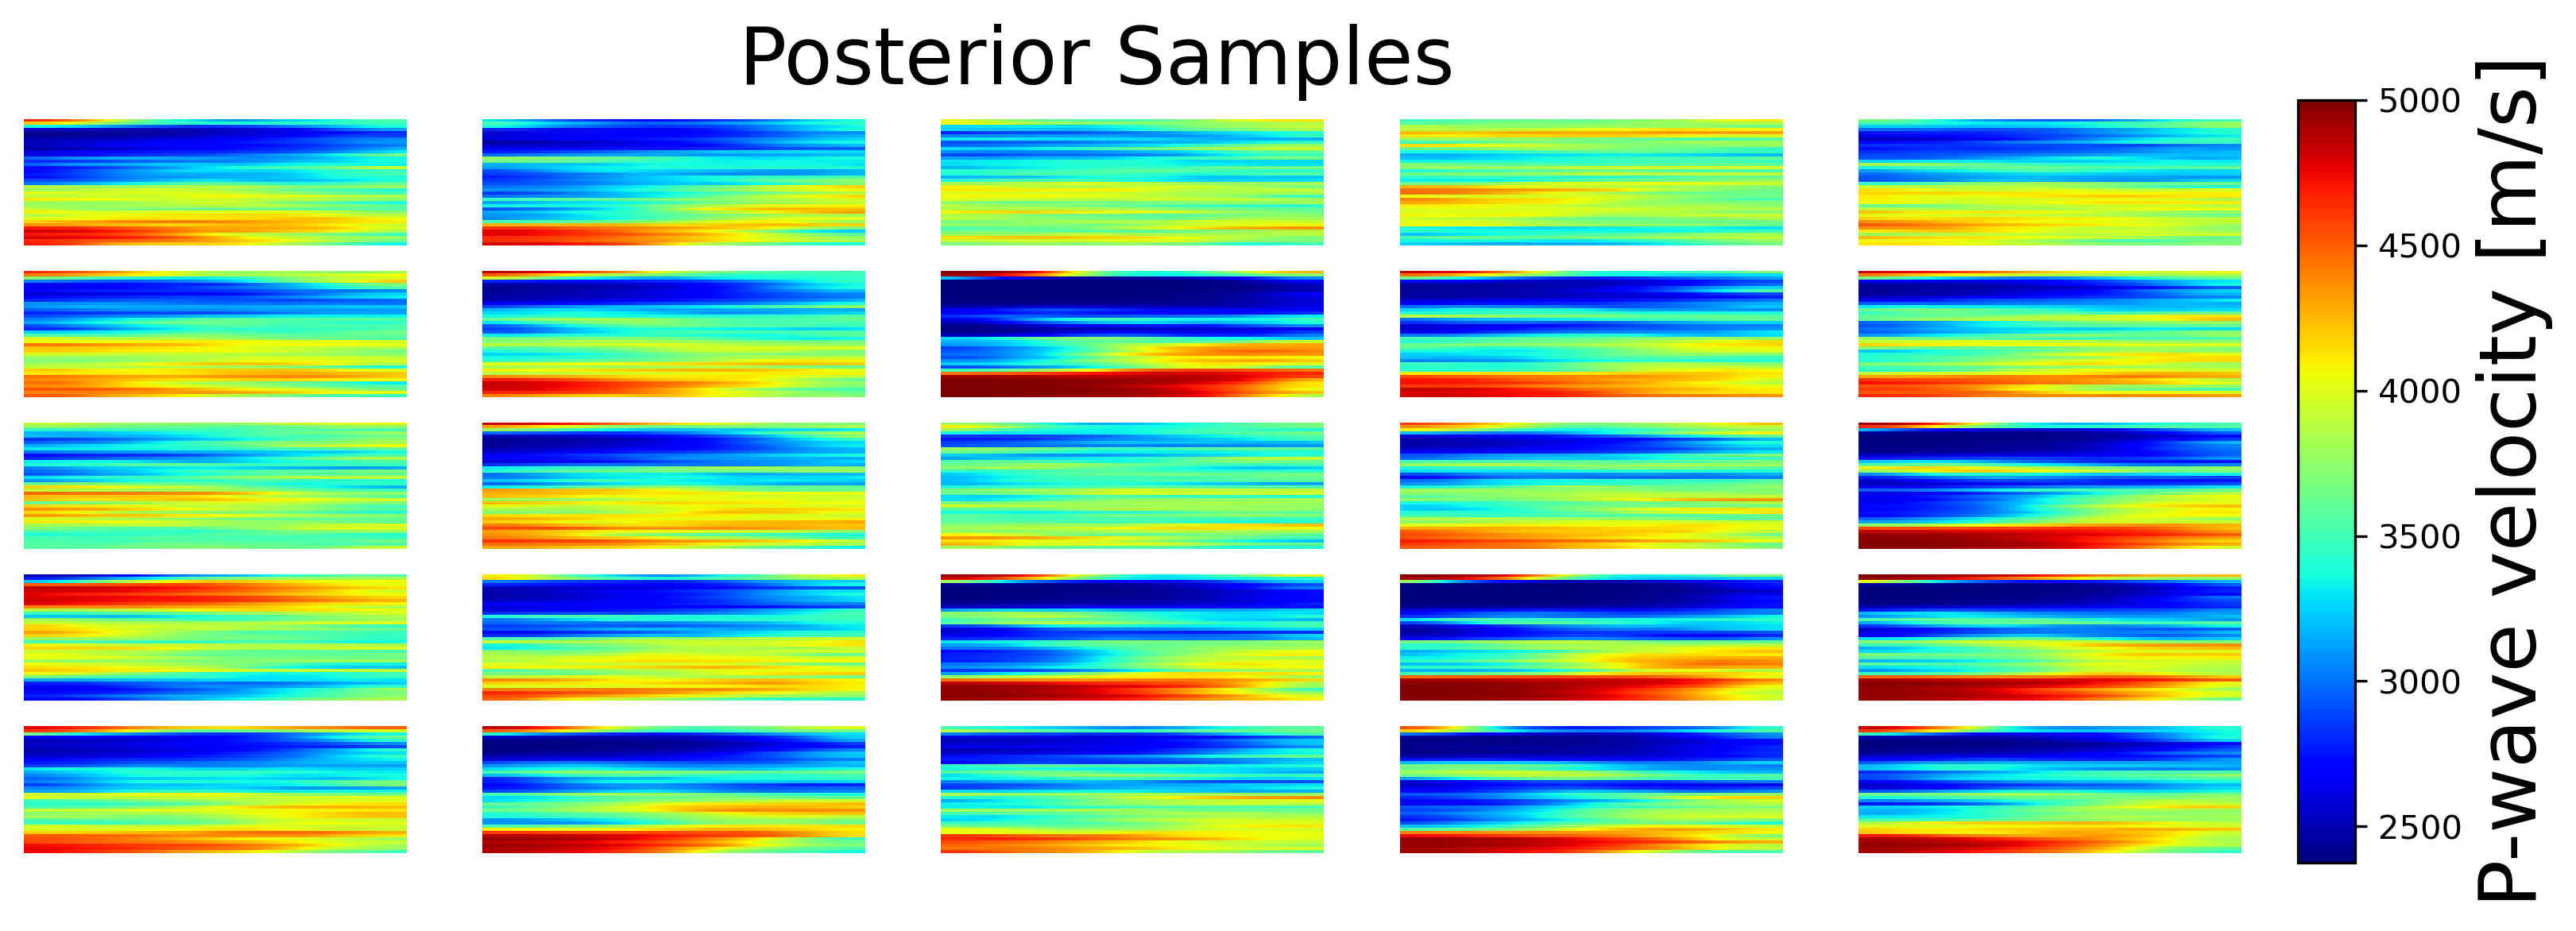

..................

KeyboardInterrupt: 

In [11]:
def plot_loss(epoch_vels, loss_list):
  # Display current velocity field
  clear_output(wait=True)
  print('Iteration', int(epoch))

  plt.figure(figsize=(10,7), dpi=300)
  # Plot the true velocity
  plt.subplot(321)
  plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
  plt.legend(loc='upper right',fontsize=labelsize-8)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(a) True Velocity Model",fontsize=labelsize)

  # Plot the initial velocity
  plt.subplot(322)
  plt.imshow(tf.reshape(v_init, [nz,nx]),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance [m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(b) Initial Mean",fontsize=labelsize)

  # Plot the velocity field at current iteration
  plt.subplot(323)
  plt.imshow(post_mean.numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(c) Posterior Mean",fontsize=labelsize)

  # Plot the velocity field at current iteration
  plt.subplot(324)
  plt.imshow(post_std.numpy().reshape((nz,nx)),vmin=0,cmap='Reds',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("Std [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(d) Posterior Uncertainties",fontsize=labelsize)

  # Plot the velocity field at current iteration
  plt.subplot(325)
  plt.imshow(epoch_vels[0].numpy().reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
  cbar = plt.colorbar()
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
  plt.xlabel('Distance x[m]', fontsize=labelsize-4)
  plt.ylabel('Depth [m]', fontsize=labelsize-4)
  plt.title("(c) Posterior Sample",fontsize=labelsize)

  # Display loss track
  plt.subplot(326)
  plt.plot(loss_list,lw=1)
  # Set the x-axis tick formatter to scientific notation
  formatter = ScalarFormatter(useMathText=True)
  formatter.set_scientific(True)
  formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.legend(['Loss'])
  plt.xlim(xmin=0)
  plt.ylim(ymin=0)
  plt.xlabel('Epoch', fontsize=labelsize-4)
  plt.ylabel('Loss', fontsize=labelsize-4)
  plt.title("(d) Optimization History",fontsize=labelsize)

  plt.tight_layout()
  plt.show()

  # Plot realizations
  fig = plt.figure(figsize=(12, 4),dpi=300)
  plt.suptitle("Posterior Samples", fontsize=24)
  for k in range(25):
    plt.subplot(5, 5, k+1)
    plt.imshow(epoch_vels[k].numpy().reshape((nz,nx)),cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
    plt.axis('off')
  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cb = plt.colorbar(cax=cax)
  cb.set_label("P-wave velocity [m/s]", fontsize=24)
  plt.show()

def kozachenko_estimator(X, k):
  # Find the indices of the k-th nearest neighbors for each sample
  # distances: A tensor of pairwise distances (z, z)
  # k: The value of k for the k-th nearest neighbor
  M = X.shape[0]
  distance = []
  for i in range(M):
      dist_i = tf.sqrt(tf.reduce_sum((X - X[i,:])**2, axis=1))
      log_rho_i = tf.math.log(tf.sort(dist_i)[k+1])
      distance.append(log_rho_i)
  return dim_z * tf.reduce_mean(log_rho_i)

# Kozachenko-Leonenko estimator: k = sqrt(M)
k = int(np.round(np.sqrt(BATCH_SIZE)))

for epoch in range(800):
  # grad = tape.gradient(J, v_gan)
  with tf.GradientTape(persistent=True) as tape:
    # Pass noise through Inference Network I
    noise_w = tf.random.normal([BATCH_SIZE, dim_w]) 
    noise_z = inference_network(noise_w, training=False)
    epoch_losses = []
    epoch_vels = []
    for j in range(BATCH_SIZE):
      print('.',end='')
      seed = noise_z[j:j+1,:]
      seed = tf.reshape(seed, [dim_w,1]) 
      m = linear_generator(seed, Lt)
      vel = mapping(m, vmin, vmax)
      vel = tf.reshape(vel,[-1])
      # # Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
      # vel = tf.reshape(Gz, -1)
      # Forward propagation & Adjoint back propagation
      J = dJ_dm(vel)
      neg_log_post = J/(1e-6+sigma2) + tf.reduce_sum(seed**2)
      # Save generated velocity fields and loss
      epoch_vels.append(vel)
      epoch_losses.append(neg_log_post)

    # Compute Posterior Mean velocity
    post_mean = tf.reduce_mean(epoch_vels,axis=0)
    post_std = tf.math.reduce_std(epoch_vels,axis=0)
    # Negative Entropy loss
    entropy = kozachenko_estimator(noise_z, k) 
    # Compute averate loss of this epoch's batch
    epoch_loss = tf.reduce_mean(epoch_losses) - entropy

    # Save the model every 100 epochs
    if (epoch + 1) % 100 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  # Save loss
  loss_tracker.append(epoch_loss)  
  plot_loss(epoch_vels, loss_tracker)
  
  # Compute gradient of loss w.r.t.  
  grad = tape.gradient(epoch_loss, inference_network.trainable_variables)
  # print('Sum of dJ|dw',sum([tf.reduce_sum(tf.abs(g)) for g in grad]).numpy())
  inference_optimizer.apply_gradients(zip(grad, inference_network.trainable_variables))

## Posterior Samples

..................................................

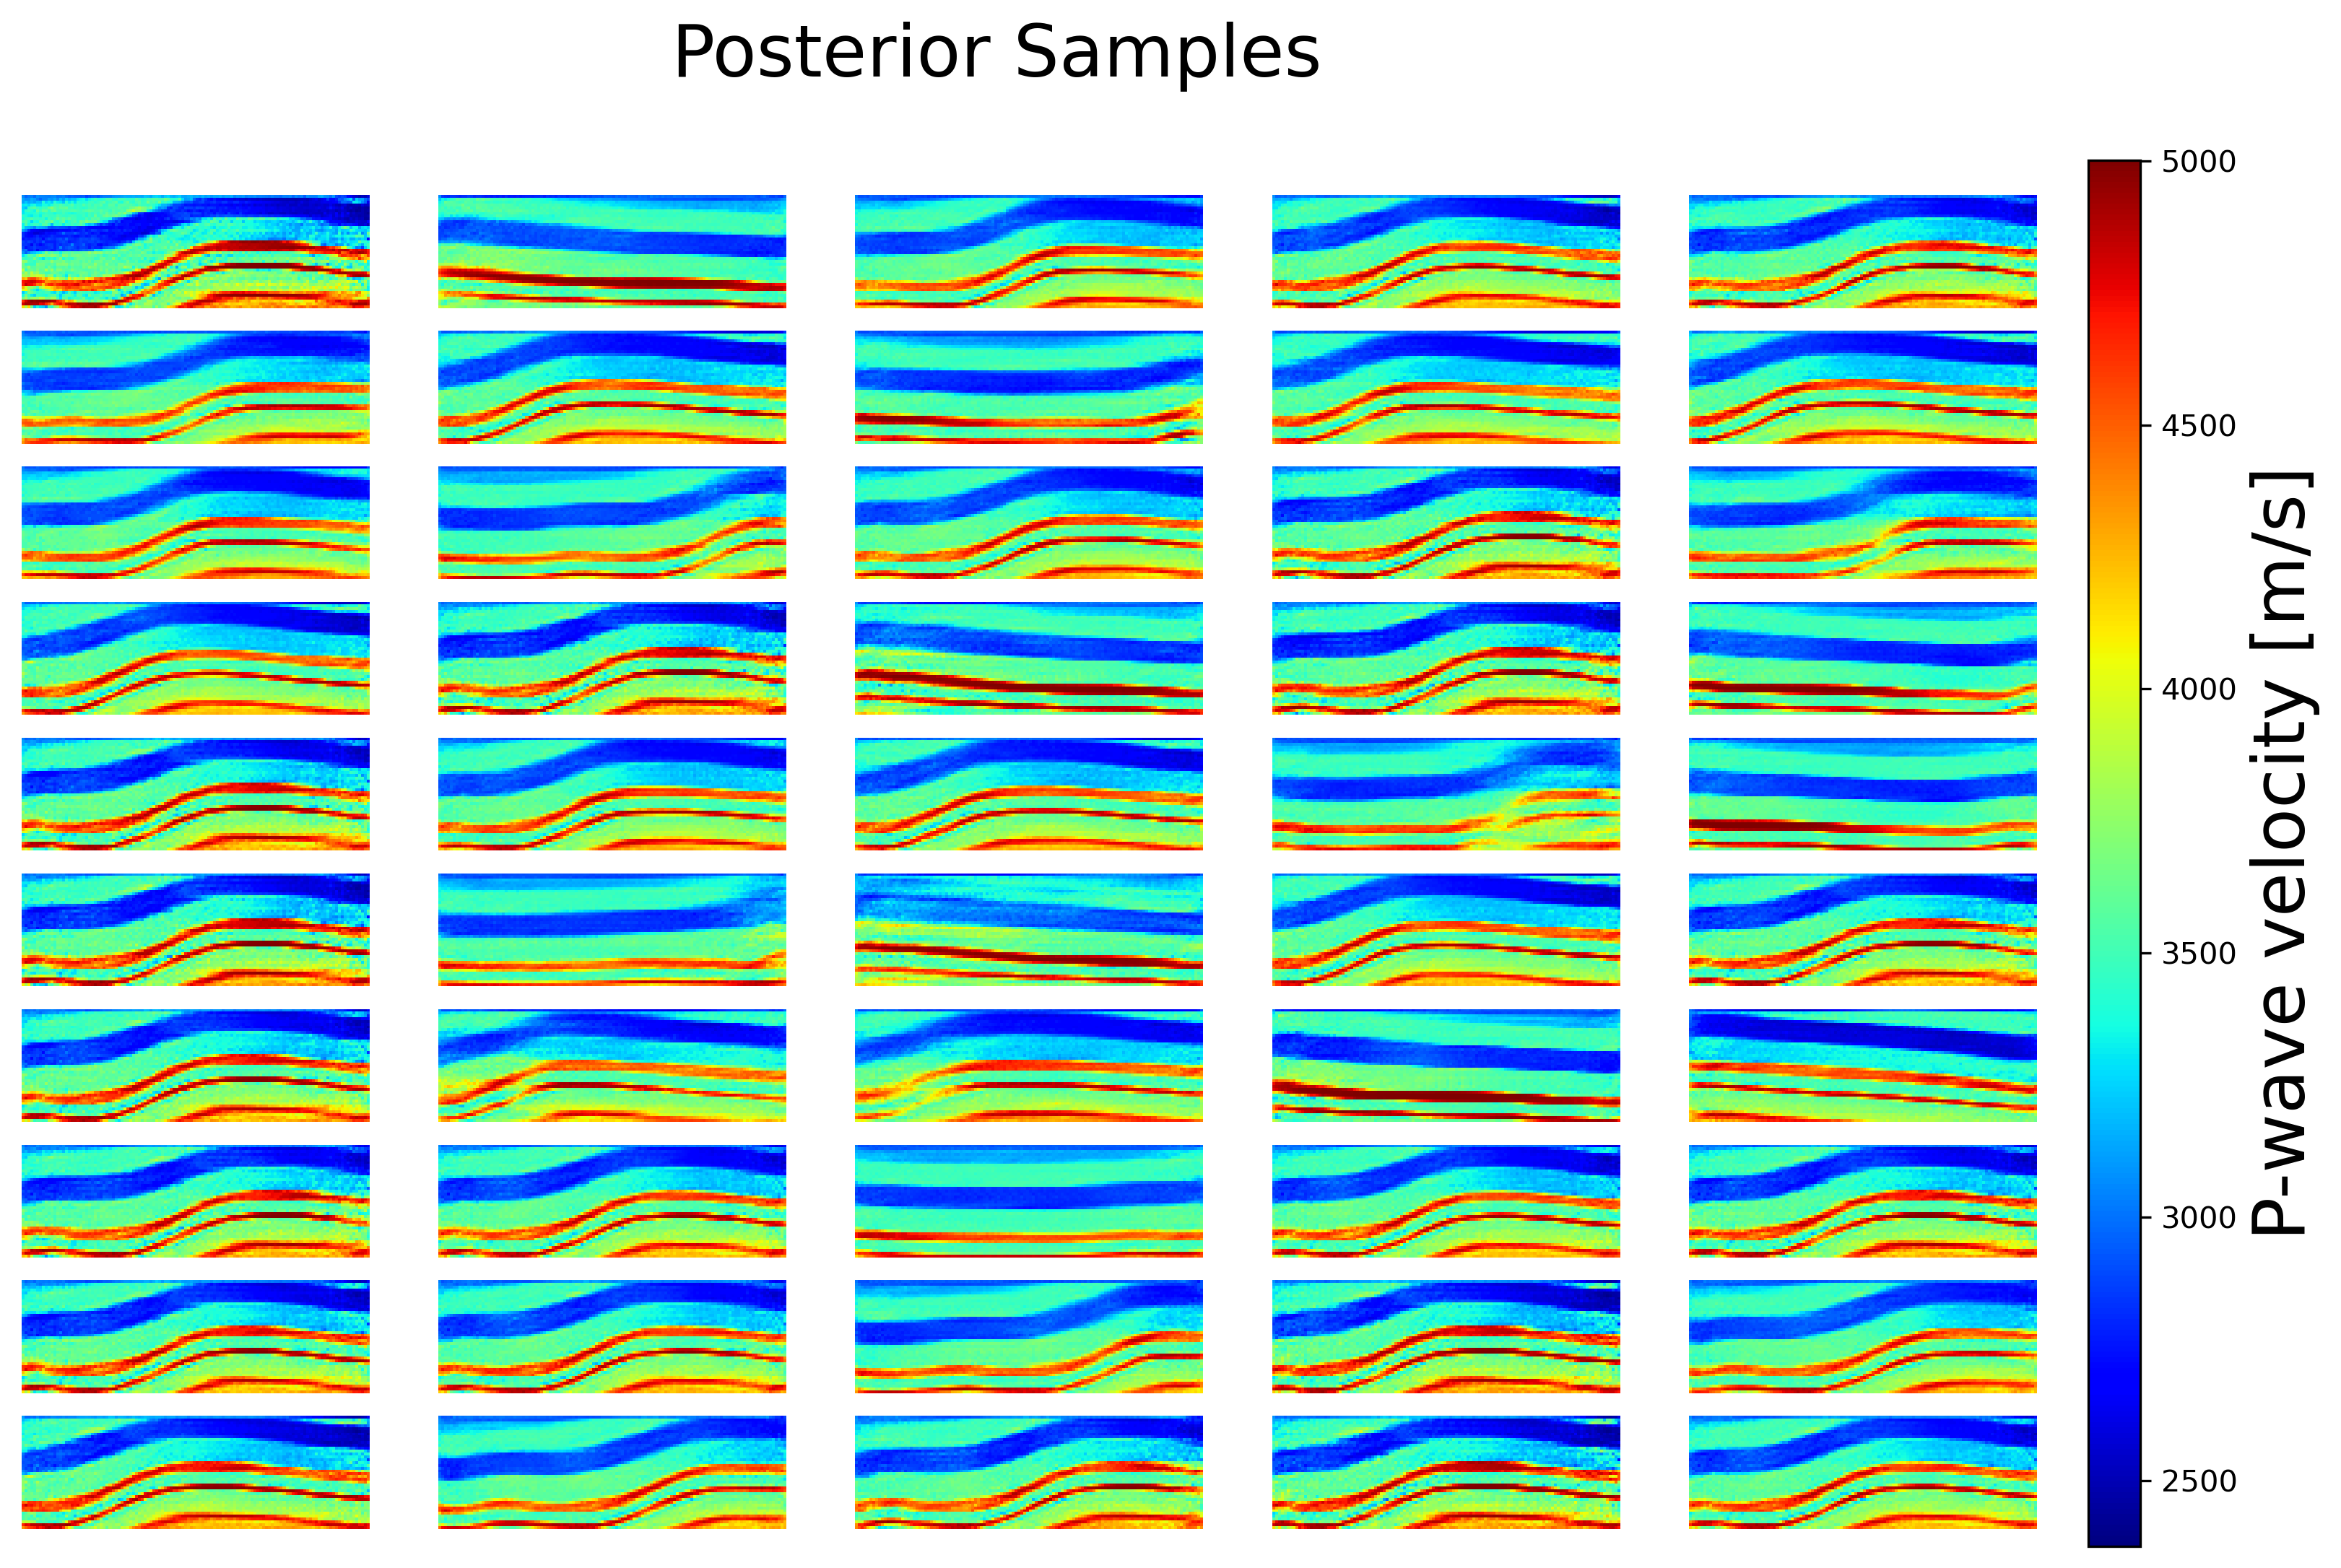

In [ ]:
epoch_vels = []

# Compute initial mean velocity
for _ in range(50):
  print('.',end='')
  # Sample from w distribution
  noise_w = tf.random.normal([1, dim_w])
  # Pass noise through Inference Network I
  noise_z = inference_network(noise_w, training=False)
  # Generate image from I(w)
  Gz = cond_generator(noise_z, training=False)
  Gz = inverse_norm(Gz[0,:,:,0],vmin,vmax)
  m = tf.reshape(Gz, -1)
  # Save generated velocity fields and loss
  epoch_vels.append(m)


